To begin copy this notebook to your own drive:

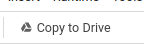


### Submission Instructions:
1. **Restart the kernel** (in the menubar, select Runtime$\rightarrow$Restart runtime)
2. **Download the notebook** (in the menubar, select File$\rightarrow$Download .ipynb)
3. **Upload the downloaded notebook (.ipynb file) to your repository**.


Make sure you fill in any place that says `YOUR CODE HERE`, and that no tests fail.  

Note: To use a GPU, do the following: Runtime$\rightarrow$Change runtime type$\rightarrow$ GPU

In [1]:
import gdown
import nltk
gdown.download('https://drive.google.com/uc?export=download&id=1PFOG06NEsTL6VieKQjMk1oNzyzcUtiWn', 'glove.npy', quiet=False)
gdown.download('https://drive.google.com/uc?export=download&id=1-3SxpirQjmX-RCRyRjKdP2L7G_tNgp00', 'vocab.json', quiet=False)

nltk.download('punkt')

Downloading...
From (original): https://drive.google.com/uc?export=download&id=1PFOG06NEsTL6VieKQjMk1oNzyzcUtiWn
From (redirected): https://drive.google.com/uc?export=download&id=1PFOG06NEsTL6VieKQjMk1oNzyzcUtiWn&confirm=t&uuid=21cf2773-c214-44bf-8150-2eebb5a14eec
To: /content/glove.npy
100%|██████████| 480M/480M [00:12<00:00, 38.8MB/s]
Downloading...
From: https://drive.google.com/uc?export=download&id=1-3SxpirQjmX-RCRyRjKdP2L7G_tNgp00
To: /content/vocab.json
100%|██████████| 7.69M/7.69M [00:00<00:00, 20.0MB/s]
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [2]:
!pip install datasets
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 18.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 21.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 20.1 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 

In [3]:
import numpy as np
from datasets import load_dataset


raw_datasets = load_dataset("imdb")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


ReadTimeout: (ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: 8c1051b0-b310-4a0f-bdbf-3ad894fca2d2)')

In [ ]:

from nltk.tokenize import word_tokenize
import json

with open("vocab.json") as f:
  vocab = json.load(f)

def tokenize_function(example):
  sentences = [x.lower() for x in example['text']]
  tokenized_sentences = [word_tokenize(x) for x in sentences]
  tokenized_idx = [[vocab[word] if word in vocab else vocab["unk"] for word in x] for x in tokenized_sentences]
  max_size = max([len(x) for x in tokenized_idx])
  final_tokenized_idx = tokenized_idx

  return {"labels":example['label'],'input_ids':final_tokenized_idx}

In [ ]:
small_train_dataset = raw_datasets['train'].shuffle(seed=42).map(tokenize_function,batched=True)
small_eval_dataset = raw_datasets['test'].shuffle(seed=42).map(tokenize_function,batched=True)

In [ ]:
def pad_sequence_to_length(
    sequence,
    desired_length: int,
    default_value = lambda: 0,
    padding_on_right: bool = True,
):
    sequence = list(sequence)
    # Truncates the sequence to the desired length.
    if padding_on_right:
        padded_sequence = sequence[:desired_length]
    else:
        padded_sequence = sequence[-desired_length:]
    # Continues to pad with default_value() until we reach the desired length.
    pad_length = desired_length - len(padded_sequence)
    # This just creates the default value once, so if it's a list, and if it gets mutated
    # later, it could cause subtle bugs. But the risk there is low, and this is much faster.
    values_to_pad = [default_value()] * pad_length
    if padding_on_right:
        padded_sequence = padded_sequence + values_to_pad
    else:
        padded_sequence = values_to_pad + padded_sequence
    return padded_sequence

In [ ]:
from datasets import load_metric

metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    logits = eval_pred.predictions
    labels = eval_pred.label_ids
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [ ]:
from dataclasses import dataclass

@dataclass
class DataCollatorWithPadding:

  def __call__(self, features):
    features_dict={}
    if "labels" in features[0]:

      features_dict["labels"] = torch.tensor([x.pop("labels") for x in features]).long()

    input_ids = [x.pop("input_ids") for x in features]
    max_len = max(len(x) for x in input_ids)
    masks = [[1]*len(x) for x in input_ids]

    features_dict["input_ids"] = torch.tensor([pad_sequence_to_length(x,max_len) for x in input_ids]).long()
    features_dict["attention_masks"] = torch.tensor([pad_sequence_to_length(x,max_len) for x in masks]).long()

    return features_dict


In [ ]:
from torch import nn
import torch
#Use nn.Sequential and nn.Linear for the network, and nn.CrossEntropyLoss for the loss.
#Make sure that the final layer has output dimension of size 2.
class DAN(nn.Module):
    def __init__(self, p=0, num_hidden_layers=1, hidden_size=256, activation_func=nn.ReLU()):
        super().__init__()
        self.num_labels = 2
        self.p = p
        self.num_hidden_layers = num_hidden_layers
        self.hidden_size = hidden_size
        self.activation_func = activation_func

        # Define the embedding layer (assuming GloVe embeddings are used)
        self.embeddings = nn.Embedding.from_pretrained(torch.FloatTensor(np.load("glove.npy")))

        # YOUR CODE HERE
        layers = []
        if self.num_hidden_layers == 0:
            layers = [nn.Linear(self.embeddings.embedding_dim, self.num_labels)]
        else:
            for i in range(num_hidden_layers):
                if i == 0:
                    layers.append(nn.Linear(self.embeddings.embedding_dim, self.hidden_size))
                else:
                    layers.append(nn.Linear(self.hidden_size, self.hidden_size))
                    layers.append(self.activation_func)
            layers.append(nn.Linear(self.hidden_size, self.num_labels))
        self.classifier = nn.Sequential(*layers)
        self.loss = nn.CrossEntropyLoss()
        # END YOUR END

    def forward(self, input_ids, attention_masks, labels=None, **kwargs):
        # YOUR CODE HERE
        embeddings = self.embeddings(input_ids)
        if self.training:
            mask = torch.bernoulli(torch.ones_like(attention_masks, dtype=torch.float) * (1 - self.p))
            attention_masks = attention_masks.float() * mask
            embeddings = embeddings * mask.unsqueeze(-1)
        avg = torch.sum(embeddings, dim=1) / torch.sum(attention_masks, dim=1).unsqueeze(-1)
        # END YOUR END

        res = self.classifier(avg)
        loss = self.loss(res, labels)
        return {"loss": loss, "logits": res}

In [ ]:
#Hint: You may want to look at https://huggingface.co/transformers/main_classes/callback.html
from transformers import Trainer
from transformers import TrainingArguments
from transformers.integrations import TensorBoardCallback


co = DataCollatorWithPadding()
training_args = TrainingArguments("DAN",
                                  # YOUR CODE HERE
                                  num_train_epochs=20, #must be at least 10.
                                  per_device_train_batch_size=128,
                                  per_device_eval_batch_size=8,
                                  learning_rate=0.01,
                                  logging_strategy="epoch",
                                  # END YOUR END

                                  save_total_limit=2,
                                  log_level="error",
                                  evaluation_strategy="epoch")
model = DAN()



trainer1 = Trainer(
    model=model,
    data_collator=co,
    args=training_args,
    callbacks = [
                 # YOUR CODE HERE
                  TensorBoardCallback
                 # END YOUR END
    ],
    train_dataset=small_train_dataset,
    eval_dataset=small_eval_dataset,
    compute_metrics=compute_metrics,
)


In [ ]:
trainer1.train()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Extract evaluation accuracies from the log history
eval_accuracy = [d['eval_accuracy'] for d in trainer1.state.log_history if 'eval_accuracy' in d]

# Determine the maximum accuracy
max_accuracy = np.max(eval_accuracy)

# Plot the evaluation accuracies
plt.plot(np.arange(1, len(eval_accuracy) + 1), eval_accuracy, label='Eval Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Eval Accuracy')

# Add a horizontal line at the maximum accuracy
plt.axhline(y=max_accuracy, color='r', linestyle='dashed', label=f'Max Accuracy: {max_accuracy:.2f}')

# Include the maximum accuracy in the y-axis ticks
plt.yticks(list(plt.yticks()[0]) + [max_accuracy])

# Add a legend
plt.legend()

# Display the plot
plt.show()


In [ ]:
from torch import nn
import torch


#Redifining DAN():
class DynamicDAN(nn.Module):
  def __init__(self, p=0.0, hidden_layers=1, hidden_size=[256], activation_func=nn.ReLU()):
          super().__init__()
          self.num_labels = 2
          self.p = p
          self.embeddings = nn.Embedding.from_pretrained(torch.FloatTensor(np.load("glove.npy")))
          # YOUR CODE HERE
          self.embedding_size = torch.FloatTensor(np.load("glove.npy")).size(1)

          classifier_args = []
          if hidden_layers == 0:
              classifier_args = [nn.Linear(self.embeddings.embedding_dim, self.num_labels)]
          else:
              for i in range(hidden_layers):
                  if i == 0:
                      classifier_args.append(nn.Linear(self.embeddings.embedding_dim, hidden_size[i]))
                  else:
                      classifier_args.append(nn.Linear(in_features=hidden_size[i-1], out_features=hidden_size[i]))
                  classifier_args.append(activation_func)

              classifier_args.append(nn.Linear(hidden_size[len(hidden_size)-1], self.num_labels))

          self.classifier = nn.Sequential(*classifier_args)
          self.loss = nn.CrossEntropyLoss()
          # END YOUR END



  def forward(self,input_ids,attention_masks,labels=None,**kwargs):
      # YOUR CODE HERE
      # Embedding Lookup
      embeddings = self.embeddings(input_ids)
      if self.training:
            dropout_mask = torch.bernoulli(torch.ones_like(attention_masks) * (1 - self.p)).unsqueeze(-1).float()
            embeddings = embeddings * dropout_mask

      masked_embeddings = embeddings * attention_masks.unsqueeze(-1).float()

      sum_embeddings = masked_embeddings.sum(dim=1)
      sum_masks = attention_masks.sum(dim=1).unsqueeze(-1)
      avg = sum_embeddings / sum_masks
      # END YOUR END
      res = self.classifier(avg)
      loss = self.loss(res,labels)
      return {"loss":loss,"logits":res}


In [ ]:
from transformers import Trainer
from transformers import TrainingArguments
from transformers.integrations import TensorBoardCallback

co = DataCollatorWithPadding()
training_args = TrainingArguments("DynamicDAN",
                                  # YOUR CODE HERE
                                  num_train_epochs= 20, #must be at least 10.
                                  per_device_train_batch_size=128,
                                  per_device_eval_batch_size=8,
                                  learning_rate= 0.01,
                                  logging_strategy="epoch",
                                  # END YOUR END

                                  save_total_limit=2,
                                  log_level="error",
                                  evaluation_strategy="epoch")



def run_with_dropout(p):
  model = DynamicDAN(p=p)

  trainer = (Trainer(
      model=model,
      data_collator=co,
      args=training_args,
      callbacks = [
                  # YOUR CODE HERE
                  TensorBoardCallback()
                  # END YOUR END
      ],
      train_dataset=small_train_dataset,
      eval_dataset=small_eval_dataset,
      compute_metrics=compute_metrics,
  ))
  trainer.train()
  results = [d['eval_accuracy'] for d in trainer.state.log_history if 'eval_accuracy' in d ]
  return results




In [ ]:
results = []
results.append(run_with_dropout(0.1))
results.append(run_with_dropout(0.2))
results.append(run_with_dropout(0.3))
results.append(run_with_dropout(0.4))
results.append(run_with_dropout(0.5))

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

ps = [0.1, 0.2, 0.3, 0.4, 0.5]
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
for i, result in enumerate(results):
    plt.plot(np.arange(1, 21), result, label=f"p={ps[i]:.1f}")
plt.legend()
plt.show()

plt.xlabel('Dropout Prob')
plt.ylabel('Mean Accuracy')
plt.plot(ps, np.mean(results, axis=1))
plt.show()

plt.xlabel('Dropout Prob')
plt.ylabel('Last Epoch Accuracy')
plt.plot(ps, np.array(results)[:, -1])
plt.show()

In [ ]:
training_args = TrainingArguments("DAN",
                                  # YOUR CODE HERE
                                  num_train_epochs=20 , #must be at least 10.
                                  per_device_train_batch_size=128,
                                  per_device_eval_batch_size=8,
                                  learning_rate=0.01,
                                  logging_strategy="epoch",
                                  # END YOUR END

                                  save_total_limit=2,
                                  log_level="error",
                                  evaluation_strategy="epoch")
resultsc = []
trainersc = []
for num_layers in range(0, 4):
  model = DAN(num_hidden_layers=num_layers)
  trainersc.append(Trainer(
      model=model,
      data_collator=co,
      args=training_args,
      callbacks = [
                  # YOUR CODE HERE
                    TensorBoardCallback
                  # END YOUR END
      ],
      train_dataset=small_train_dataset,
      eval_dataset=small_eval_dataset,
      compute_metrics=compute_metrics,
  ))
  trainersc[-1].train()
  resultsc.append([d['eval_accuracy'] for d in trainersc[-1].state.log_history if 'eval_accuracy' in d ])


In [ ]:
# Plots
plt.xlabel('Epoch')
plt.ylabel('Eval Accuracy')
for i, result in enumerate(resultsc):
  plt.plot(np.arange(1, num_epochs + 1), result, label=f"{i} hidden layers")
plt.legend()
plt.show()

plt.xlabel('Num Hidden Layers')
plt.ylabel('Mean Eval Accuracy')
plt.plot(np.arange(4), np.mean(resultsc, axis=1))
plt.show()

plt.xlabel('Num Hidden Layers')
plt.ylabel('Last Epoch Eval Accuracy')
plt.plot(np.arange(4), np.array(resultsc)[:, -1])
plt.show()




In [ ]:
from transformers import Trainer
from transformers import TrainingArguments
from transformers.integrations import TensorBoardCallback

co = DataCollatorWithPadding()
training_args = TrainingArguments("DAN",
                                  # YOUR CODE HERE
                                  num_train_epochs= 20, #must be at least 10.
                                  per_device_train_batch_size=128,
                                  per_device_eval_batch_size=8,
                                  learning_rate= 0.01,
                                  logging_strategy="epoch",
                                  # END YOUR END

                                  save_total_limit=2,
                                  log_level="error",
                                  evaluation_strategy="epoch")


def run_with_activation_function(activation_function):
  model = DynamicDAN(activation_func = activation_function)

  trainer_func=(Trainer(
      model=model,
      data_collator=co,
      args=training_args,
      callbacks = [
                  # YOUR CODE HERE
                  TensorBoardCallback()
                  # END YOUR END
      ],
      train_dataset=small_train_dataset,
      eval_dataset=small_eval_dataset,
      compute_metrics=compute_metrics,
  ))
  trainer_func.train()
  results_func = [d['eval_accuracy'] for d in trainer_func.state.log_history if 'eval_accuracy' in d ]
  return results_func

In [ ]:
results_relu = run_with_activation_function(nn.ReLU())
results_sigmoid = run_with_activation_function(nn.Sigmoid())
results_mish = run_with_activation_function(nn.Mish())

In [ ]:
from matplotlib import pyplot as plt
import numpy as np

resultsd = [results_relu, results_sigmoid, results_mish]
activations = ['ReLU', 'Sigmoid', 'Mish']
plt.xlabel('Epoch')
plt.ylabel('Eval Accuracy')
for i, result in enumerate(resultsd):
  plt.plot(np.arange(1, 21), result, label=f"{activations[i]}")
plt.legend()
plt.show()

In [ ]:
predictions = trainera.predict(small_eval_dataset)
predicted_labels = np.argmax(predictions[0], axis=1)
labels = np.array(small_eval_dataset['labels'])
wrong_predictions_idx = (predicted_labels != labels).nonzero()[0]
wrong_idx = np.random.choice(wrong_predictions_idx, size=5, replace=False)
wrong_texts = np.array(small_eval_dataset['text'])[wrong_idx]
for i, (idx, text) in enumerate(zip(wrong_idx, wrong_texts)):
  print(f"text {i}:")
  print(f"prediction: {predicted_labels[idx]}, label: {labels[idx]}")
  print(f"model output: {predictions[0][idx]}")
  print(text)
